***
***


# <center>Otimização dos Hiperparâmetros</center>

<center><img src="https://sigmoidal.ai/wp-content/uploads/2019/08/boosted_stumps.gif"></center>

***
***

**Bibliotecas Utilizadas**

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts

**Importando base de dados**

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


**Separando os dados de treino e teste**

In [3]:
# Fixando um seed
np.random.seed(2020)

# Separando todos os dados em variáveis genéricas x e y
x = dados[['preco', 'idade_do_modelo', 'km_por_ano']]
y = dados['vendido']

# Utilizando o train_test_split da biblioteca do scikit-learning
train_x, test_x, train_y, test_y = tts(x, y, test_size=.2, stratify=y)

**Criando um Algoritmo de Base - Baseline**

In [4]:
from sklearn.dummy import DummyClassifier

In [5]:
# Instânciando o DummyClassifier
dummy = DummyClassifier(strategy='stratified', random_state=2020)

# Visualizando o estimador
dummy

DummyClassifier(constant=None, random_state=2020, strategy='stratified')

In [6]:
# Treinando o estimador
dummy.fit(train_x, train_y)

DummyClassifier(constant=None, random_state=2020, strategy='stratified')

In [7]:
# Visualizando a Acurácia do Modelo / Taxa de acerto
print(f'Accuracy-: {(dummy.score(test_x, test_y) * 100):.2f}%')

Accuracy-: 50.15%


### Modelo utilizando arvore de decisão

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [9]:
# Instânciando um DecisionTreeClassifer
modelo = DecisionTreeClassifier(max_depth=2, random_state=2020)

# Visualizando o modelo
modelo

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [10]:
# Treinando o DecisionTreeClassifier
modelo.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [11]:
# Gerando previsões com o modelo
previsoes = modelo.predict(test_x)

# Accuracy
print(f'Accuracy-: {(accuracy_score(test_y, previsoes) * 100):.2f}%')

Accuracy-: 76.05%


## Visualizando a arvore

In [12]:
from sklearn.tree import export_graphviz
import graphviz

In [13]:
dot_data = export_graphviz(modelo, feature_names=x.columns, rounded=True, class_names=['Não vendido', 'Vendido'],
                          filled=True)
grafico = graphviz.Source(dot_data)

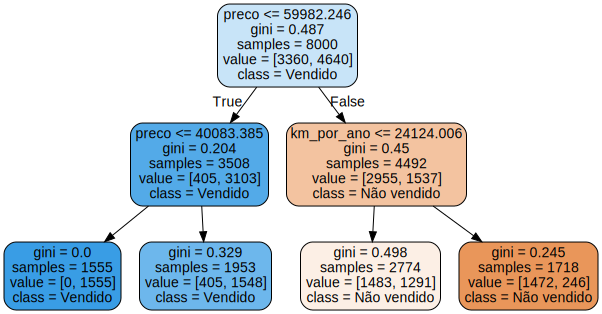

In [14]:
grafico

## Otimizando os Hiperparâmetros - GridSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV, KFold

In [16]:
params = {'max_depth' : [3],
          'criterion' : ['entropy'],
          'min_samples_leaf' : [1],
          'min_samples_split' : [2],
          'random_state' : [1],
          'splitter' : ['best'],
          'max_features' : ['auto']}

In [17]:
busca = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=KFold(n_splits=10, shuffle=True), return_train_score=True)
busca.fit(x, y)

resultados = pd.DataFrame(busca.cv_results_)

In [18]:
busca.best_score_

0.7869

In [19]:
busca.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 1,
 'splitter': 'best'}

**Validando o Estimador - Nested cross validate**

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
results = cross_val_score(busca, x, y, cv=KFold(n_splits=10, shuffle=True, random_state=1))
results

array([0.782, 0.773, 0.775, 0.791, 0.781, 0.797, 0.786, 0.8  , 0.786,
       0.798])

In [22]:
results.mean()

0.7868999999999999

## Otimizando com o RandomizedSearchSV

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [68]:
params = {'max_depth' : [3],
          'criterion' : ['entropy'], # 'gini', 'entropy'
          'min_samples_leaf' : [112],
          'min_samples_split' : [988],
          'random_state' : [129],
          'splitter' : ['best'],
          'max_features' : ['auto']} # 'auto', 'sqrt', 'log2'

In [69]:
busca = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=params, n_iter=1, cv=KFold(n_splits=10, shuffle=True, random_state=100))
busca.fit(x, y)

resultados = pd.DataFrame(busca.cv_results_)

In [70]:
busca.best_score_

0.7872

In [66]:
busca.best_params_

{'splitter': 'best',
 'random_state': 129,
 'min_samples_split': 988,
 'min_samples_leaf': 112,
 'max_features': 'auto',
 'max_depth': 3,
 'criterion': 'entropy'}

**Validando o Estimador - Nested cross validate**

In [28]:
#results = cross_val_score(busca, x, y, cv=KFold(n_splits=10, shuffle=True, random_state=1))
#results

In [29]:
#results.mean()

## Florestas Aleatórias

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
params = {'max_depth' : randint(2, 1000),
          'criterion' : ['gini', 'entropy'],
          'min_samples_split' : [3],
          'min_samples_leaf' : [3],
          'max_features' : ['auto', 'sqrt', 'log2'],
          'bootstrap' : [True, False]}

In [ ]:
busca = RandomizedSearchCV(RandomForestClassifier(), n_iter=1000, param_distributions=params)
busca.fit(x, y)